In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so
from scipy.stats import norm

## Naive Monte Carlo Valuation

In [14]:
def asset_paths(S: float, mu: float, sigma: float, div: float, T: int, n_reps: int, n_steps: int) -> np.ndarray:
  dt = T / n_steps
  nudt = (mu - div - 0.5*sigma*sigma)*dt
  sidt = sigma*np.sqrt(dt)
  z = nudt + sidt*np.random.normal(size=(n_reps, n_steps))
  paths = np.cumsum(np.concatenate((np.full((n_reps, 1), np.log(S)), z), axis=1), axis=1)

  return np.exp(paths)

In [181]:
def naive_monte_carlo(S, K, r, v, q, T, n_reps):
    paths = asset_paths(S, r, v, q, T, n_reps, 1)
    payoffs = np.maximum(paths[:,-1] - K, 0.0)
    call_prc = np.exp(-r*T) * payoffs.mean()
    se = np.std(payoffs, ddof=1) / np.sqrt(n_reps)
    return call_prc, se

In [182]:
np.random.seed(1974)
S, K, r, v, q, T, n_reps = 41.0, 40.0, 0.08, 0.30, 0.0, 1.0, 10_000
call_prc, se = naive_monte_carlo(S, K, r, v, q, T, n_reps)
call_prc, se

(np.float64(7.084015679133542), np.float64(0.1090367023667152))

In [191]:
np.random.seed(1942)
prices = np.zeros(5)
S, K, r, v, q, T, n_reps = 40.0, 40.0, 0.08, 0.30, 0.0, 91/365, 500

for i in range(5):
  prices[i], _ = naive_monte_carlo(S, K, r, v, q, T, n_reps)
  print(f"({i+1}, {prices[i]})")

print(f"Average: {prices.mean():.4f}")

(1, 2.5576681224419637)
(2, 2.6618295917699437)
(3, 3.0999344151738004)
(4, 2.9999216667520328)
(5, 2.900952271940905)
Average: 2.8441


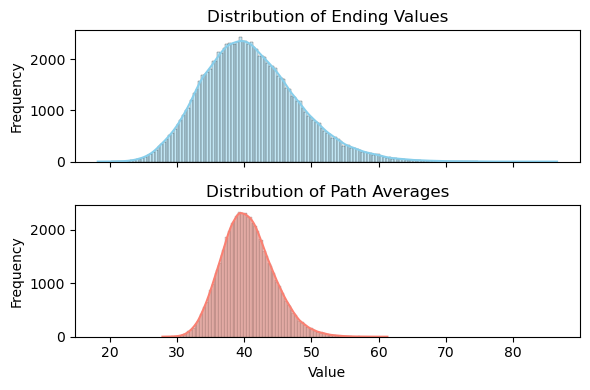

In [193]:
# Reproducing Figure 19.2
np.random.seed(2002)
S, r, v, q, T, n_reps, n_steps = 40.0, 0.08, 0.30, 0.0, 1.0/3.0, 100_000, 3
paths = asset_paths(S, r, v, q, T, n_reps, n_steps)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ending_values = paths[:, -1]  # Last column of each row
path_averages = np.mean(paths, axis=1)  # Average of each row

# Plot histogram of ending values in the upper panel
sns.histplot(ending_values, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Ending Values')
ax1.set_ylabel('Frequency')

# Plot histogram of path averages in the lower panel
sns.histplot(path_averages, kde=True, ax=ax2, color='salmon')
ax2.set_title('Distribution of Path Averages')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [212]:
def arith_asian_naive_monte_carlo(S, K, r, v, q, T, n_reps, n_steps):
    paths = asset_paths(S, r, v, q, T, n_reps, n_steps)
    avg_prc = paths.mean(axis=1)
    payoffs = np.maximum(avg_prc - K, 0.0)
    call_prc = np.exp(-r*T) * payoffs.mean()
    se = np.std(payoffs, ddof=1) / np.sqrt(n_reps)
    return call_prc, se

np.random.seed(1932)
S, K, r, v, q, T, n_reps, n_steps = 40.0, 40.0, 0.08, 0.30, 0.0, 0.25, 1_000_000, 40
call_prc, se = arith_asian_naive_monte_carlo(S, K, r, v, q, T, n_reps, n_steps)
call_prc, se

(np.float64(1.5629411365915056), np.float64(0.0022997460954052094))

## Antithetic Monte Carlo Valuation

In [60]:
def antithetic_normals(n_reps: int, n_steps: int) -> np.ndarray:
  z = np.random.normal(size=(n_reps, n_steps))
  return np.vstack((z,-z))

def asset_paths_anti(S: float, mu: float, sigma: float, div: float, T: int, n_reps: int, n_steps: int) -> np.ndarray:
  dt = T / n_steps
  nudt = (mu - div - 0.5*sigma*sigma)*dt
  sidt = sigma*np.sqrt(dt)
  z = nudt + sidt*antithetic_normals(n_reps, n_steps)
  n_reps *= 2
  paths = np.cumsum(np.concatenate((np.full((n_reps, 1), np.log(S)), z), axis=1), axis=1)

  return np.exp(paths)

In [61]:
np.random.seed(1974)
S, K, r, v, q, T = 41.0, 40.0, 0.08, 0.30, 0.0, 1.0
n_reps, n_steps = 10_000, 1
paths = asset_paths_anti(S, r, v, q, T, n_reps, n_steps)
payoffs = np.maximum(paths[:,-1] - K, 0.0)
call_prc = np.exp(-r*T) * payoffs.mean()
se = np.std(payoffs, ddof=1) / np.sqrt(n_reps*2)
call_prc, se

(np.float64(7.02627537392576), np.float64(0.07648515823610323))

## Stratified Monte Carlo Valuation

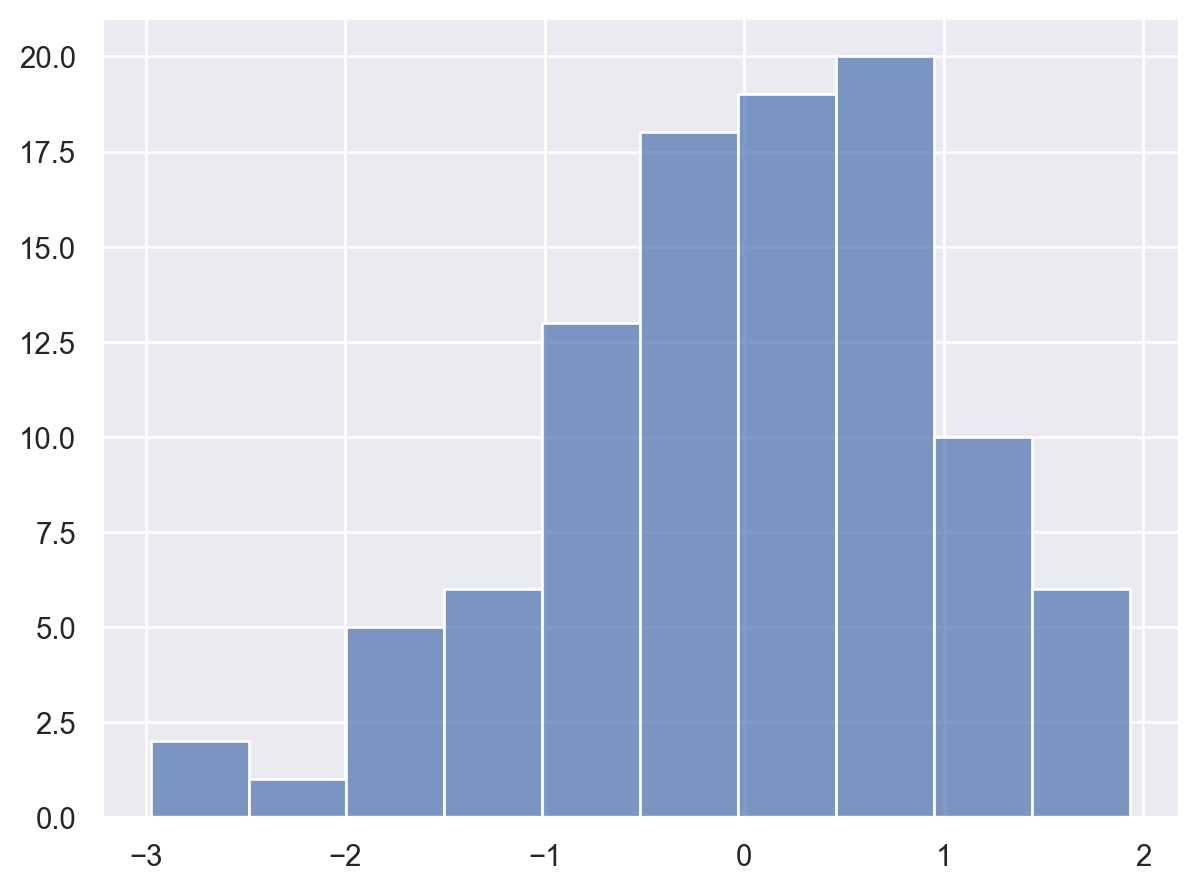

In [62]:
np.random.seed(1937)
M = 100
u = np.random.uniform(size=M)
z = norm.ppf(u)
(so.Plot(z).add(so.Bars(), so.Hist()))

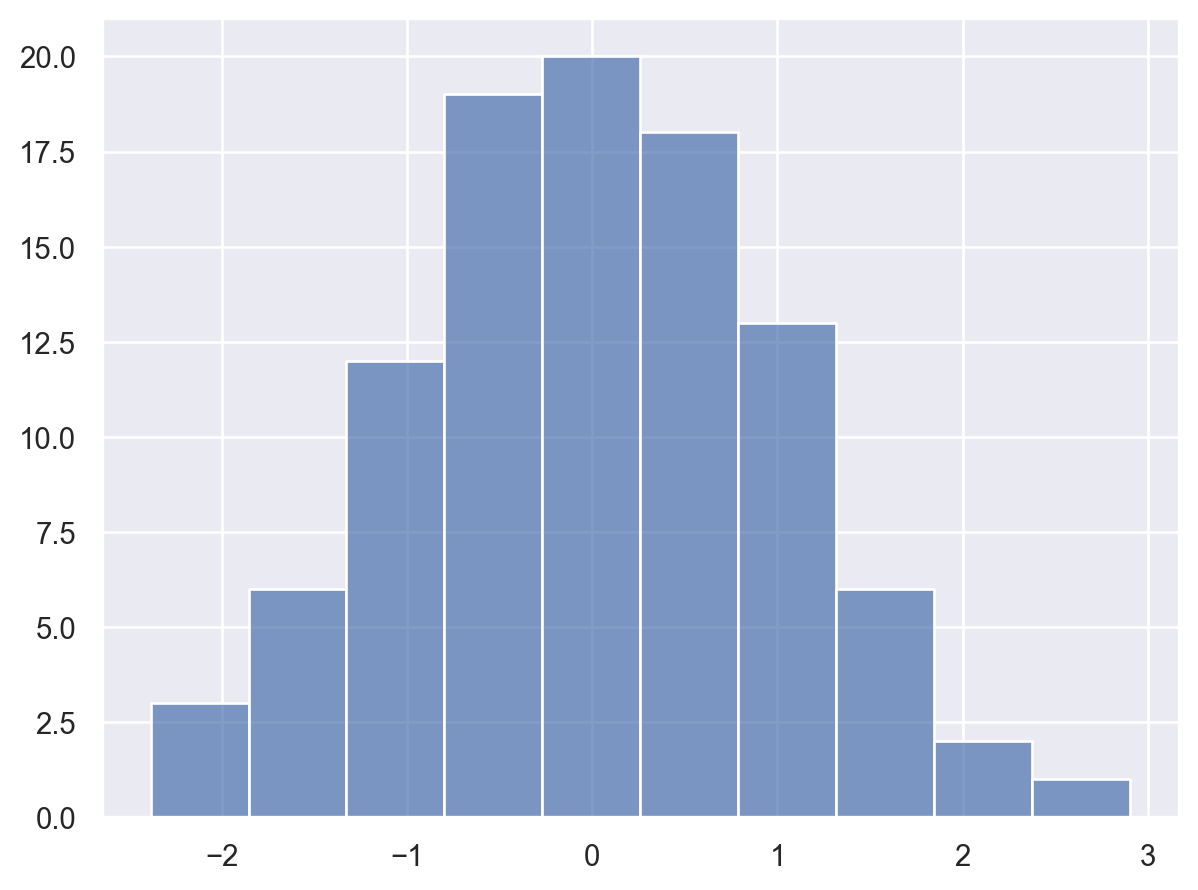

In [63]:
np.random.seed(1937)
M = 100
u = np.random.uniform(size=M)
uhat = (np.arange(M) + u) / M
zhat = norm.ppf(uhat)
(so.Plot(zhat).add(so.Bars(), so.Hist()))

In [64]:
def stratified_normals(n_reps: int) -> np.ndarray:
  u = np.random.uniform(size=n_reps)
  uhat = (np.arange(n_reps) + u) / n_reps
  zhat = norm.ppf(uhat)
  return zhat

def asset_paths_strat(S: float, mu: float, sigma: float, div: float, T: int, n_reps: int) -> np.ndarray:
  dt = T 
  nudt = (mu - div - 0.5*sigma*sigma)*dt
  sidt = sigma*np.sqrt(dt)
  z = nudt + sidt*stratified_normals(n_reps)
  paths = S * np.exp(z)

  return paths

In [65]:
np.random.seed(1943)
S, K, r, v, q, T = 41.0, 40.0, 0.08, 0.30, 0.0, 1.0
n_reps = 10_000
paths = asset_paths_strat(S, r, v, q, T, n_reps)
payoffs = np.maximum(paths - K, 0.0)
call_prc = np.exp(-r*T) * payoffs.mean()
se = np.std(payoffs, ddof=1) / np.sqrt(n_reps)
call_prc, se

(np.float64(6.960500009450156), np.float64(0.10683063852300814))

## Combining Antithetic and Stratified Monte Carlo Valuation

In [54]:
def anti_strat_normals(n_reps: int) -> np.ndarray:
  u = np.random.uniform(size=n_reps)
  utmp = (np.arange(n_reps) + u) / n_reps
  uhat = np.concatenate((utmp, 1-utmp)) 
  zhat = norm.ppf(uhat)
  return zhat

def asset_paths_anti_strat(S: float, mu: float, sigma: float, div: float, T: int, n_reps: int) -> np.ndarray:
  dt = T 
  nudt = (mu - div - 0.5*sigma*sigma)*dt
  sidt = sigma*np.sqrt(dt)
  z = nudt + sidt*stratified_normals(n_reps)
  paths = S * np.exp(z)

  return paths

In [66]:
np.random.seed(1943)
S, K, r, v, q, T = 41.0, 40.0, 0.08, 0.30, 0.0, 1.0
n_reps = 10_000
paths = asset_paths_anti_strat(S, r, v, q, T, n_reps)
payoffs = np.maximum(paths - K, 0.0)
call_prc = np.exp(-r*T) * payoffs.mean()
se = np.std(payoffs, ddof=1) / np.sqrt(n_reps*2)
call_prc, se

(np.float64(6.960500009450156), np.float64(0.07554066893810786))

### Reproducing the Lower Panel of Figure 19.3

In [174]:
def naive_monte_carlo(S, K, r, v, q, T, n_reps):
    paths = asset_paths(S, r, v, q, T, n_reps, 1)
    payoffs = np.maximum(paths[:,-1] - K, 0.0)
    call_prc = np.exp(-r*T) * payoffs.mean()
    se = np.std(payoffs, ddof=1) / np.sqrt(n_reps)
    return call_prc, se

def strat_monte_carlo(S, K, r, v, q, T, n_reps):
    paths = asset_paths_strat(S, r, v, q, T, n_reps)
    payoffs = np.maximum(paths - K, 0.0)
    call_prc = np.exp(-r*T) * payoffs.mean()
    se = np.std(payoffs, ddof=1) / np.sqrt(n_reps)
    return call_prc, se

In [175]:
n_sims, n_reps = 100, 200
naive_prc = np.zeros(n_sims)
strat_prc = np.zeros(n_sims)

for i in range(n_sims):
    naive_prc[i], _ = naive_monte_carlo(S, K, r, v, q, T, n_reps)
    strat_prc[i], _ = strat_monte_carlo(S, K, r, v, q, T, n_reps)

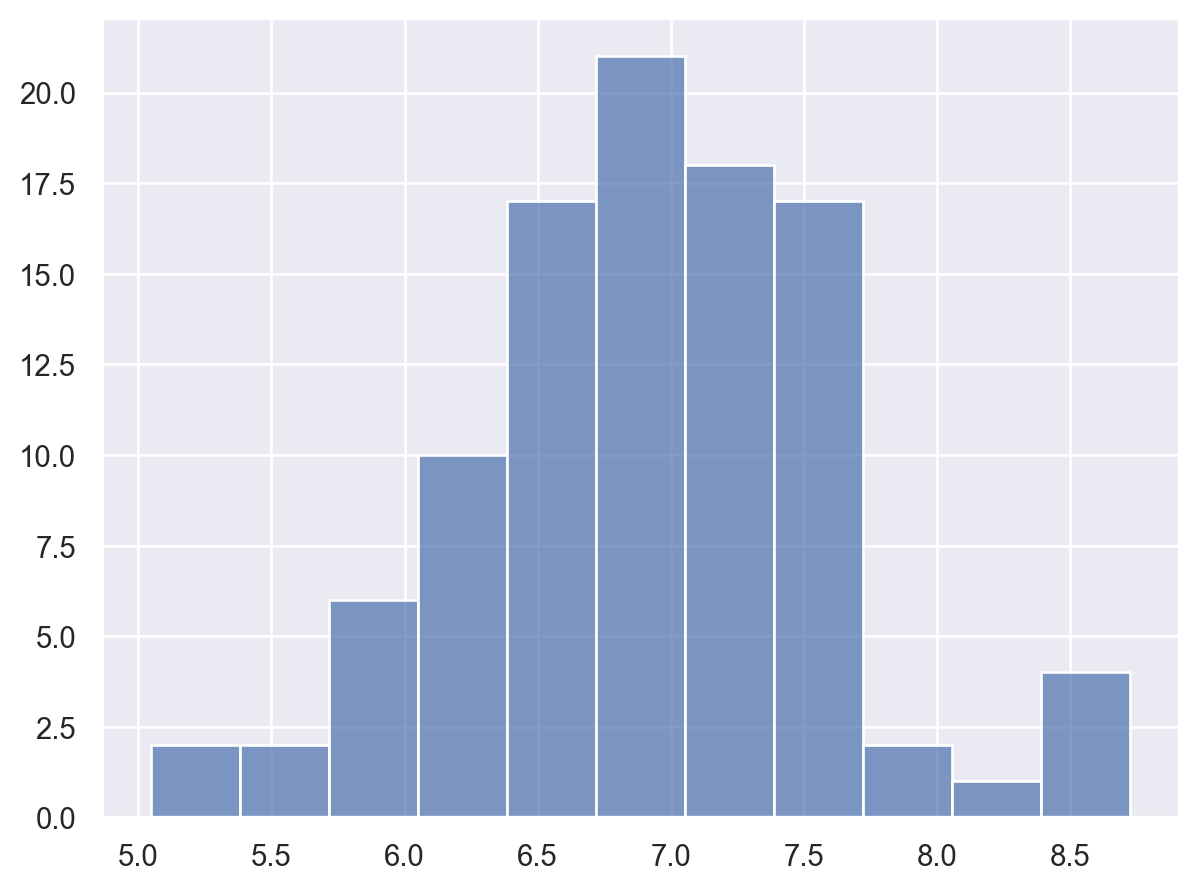

In [176]:
(so.Plot(naive_prc).add(so.Bars(), so.Hist()))

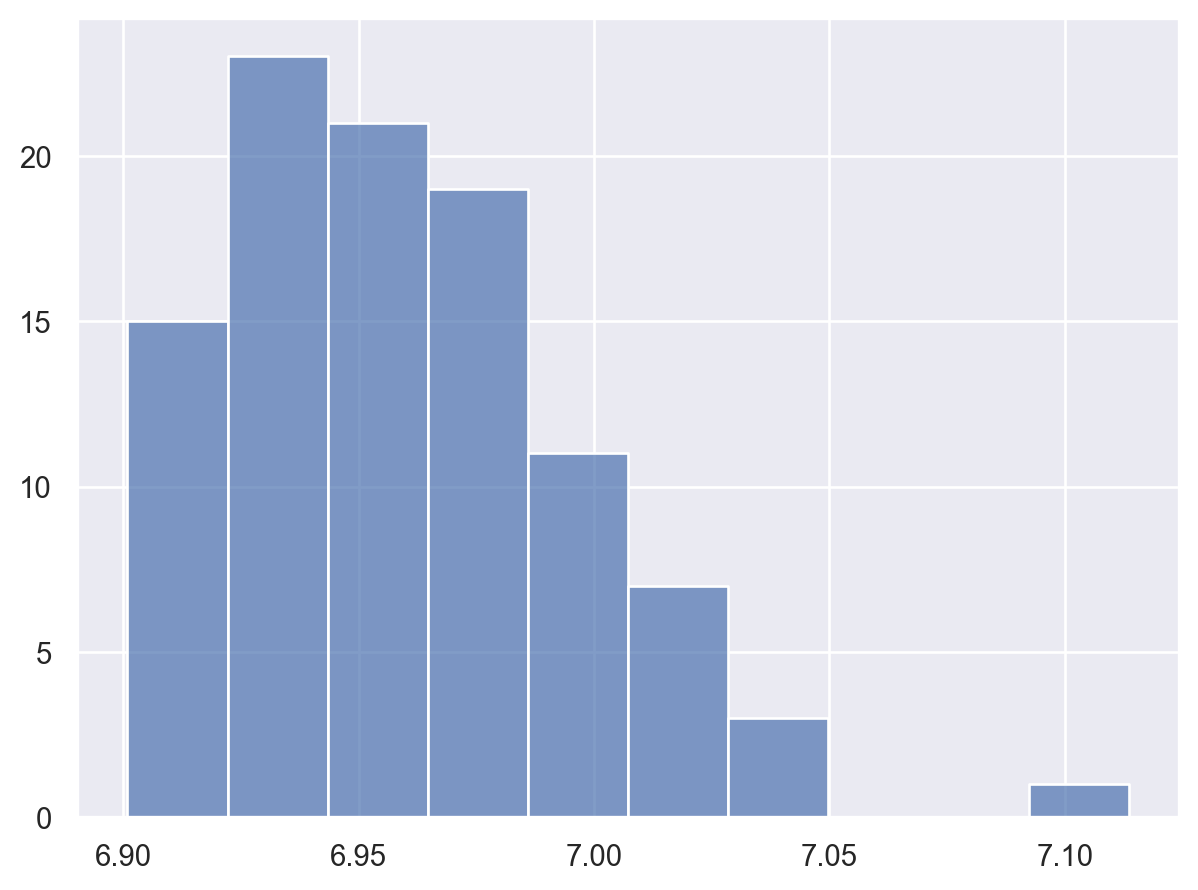

In [177]:
(so.Plot(strat_prc).add(so.Bars(), so.Hist()))

In [178]:
naive_prc.mean(), naive_prc.std(ddof=1)

(np.float64(6.916129547419845), np.float64(0.6842688054202423))

In [179]:
strat_prc.mean(), strat_prc.std(ddof=1)

(np.float64(6.959213614844665), np.float64(0.03841624055790846))

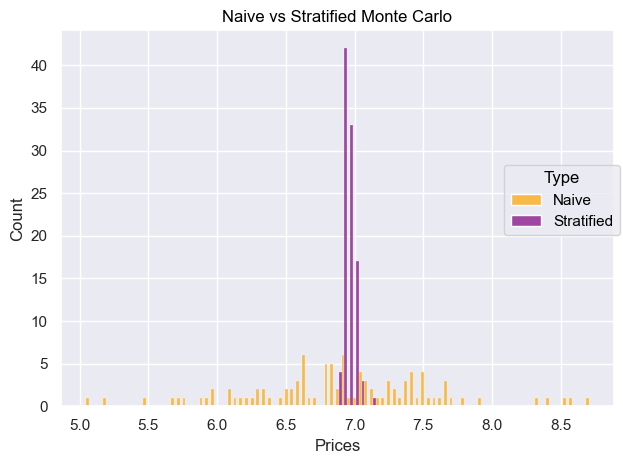

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

# Create a DataFrame to store both arrays
df = pd.DataFrame({
    'prices': np.concatenate([naive_prc, strat_prc]),
    'type': ['Naive'] * len(naive_prc) + ['Stratified'] * len(strat_prc)
})

(
    so.Plot(df, x="prices", color="type")
    .add(so.Bars(), so.Hist(), so.Dodge())  
    .scale(color=["orange", "purple"])
    .label(x="Prices", y="Count", color="Type", title="Naive vs Stratified Monte Carlo")
    #.limit(y=(0, 50))
    #.layout(size=(10, 6))
    .show()
)